## Plant disease classification with PyTorch

In [33]:
import torch
import glob
import os
import cv2
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
import numpy as np
from collections import defaultdict
import pathlib
from time import time

### Download and extract data

In [34]:
# Uncomment to download data - 1.3GB 
# !curl -L -o ~/Downloads/plant-disease-recognition-dataset.zip\
#   https://www.kaggle.com/api/v1/datasets/download/rashikrahmanpritom/plant-disease-recognition-dataset
# !unzip ~/Downloads/plant-disease-recognition-dataset.zip -d ./data

In [35]:
train_path = "./data/Train/"
test_path = "./data/Test/"
validation_path = "./data/Validation/"
train_images = glob.glob(train_path+"**/*.jpg", recursive=True)
test_images = glob.glob(test_path+"**/*.jpg", recursive=True)
validation_images = glob.glob(validation_path+"**/*.jpg", recursive=True)

In [36]:
train_images[-2:]
#len(train_images)

['./data/Train/Powdery/b34c524efdb39109.jpg',
 './data/Train/Powdery/d0bc2d0d339664f5.jpg']

In [37]:
# Memory efficient data loading
class PlantsLeavesDataset(Dataset):
    """Plants leaves dataset."""

    def __init__(self, image_paths, transform=None):
        """
        """
        self.label_map = {'Healthy': 0, 'Powdery':1, 'Rust':2}
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_paths[idx]
        image = cv2.imread(img_name)
        label_name = img_name.split('/')[-2]
        label = self.label_map[label_name]
        # label = np.array([label], dtype=float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Load entire dataset in memory. Increases speed but heavy on memory
class PlantsDataset(Dataset):
    """Plants leaves dataset."""

    def __init__(self, image_paths, transform=None):
        """
        """
        self.data = []
        self.label_map = {'Healthy': 0, 'Powdery':1, 'Rust':2}
        for path in image_paths:
            image = cv2.imread(path)
            label_name = path.split('/')[-2]
            label = self.label_map[label_name]
            if transform:
                image = transform(image)
            self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx]
    


In [38]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(35),
    #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
])

In [39]:
train_set = PlantsDataset(train_images, train_transform)
test_set = PlantsDataset(test_images, test_transform)
validation_set = PlantsDataset(validation_images, test_transform)

In [40]:
# shapes = defaultdict(int)
# for i in range(len(train_set)):
#     s = tuple(train_set[i][0].shape)
#     shapes[s] += 1
# shapes

In [41]:
batch_size = 64
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, drop_last=True, pin_memory=True)
val_loader = DataLoader(validation_set, shuffle=False, batch_size=batch_size, drop_last=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07072551..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.102104..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07970124..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1005167..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039735347..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018626953..1.0000004].


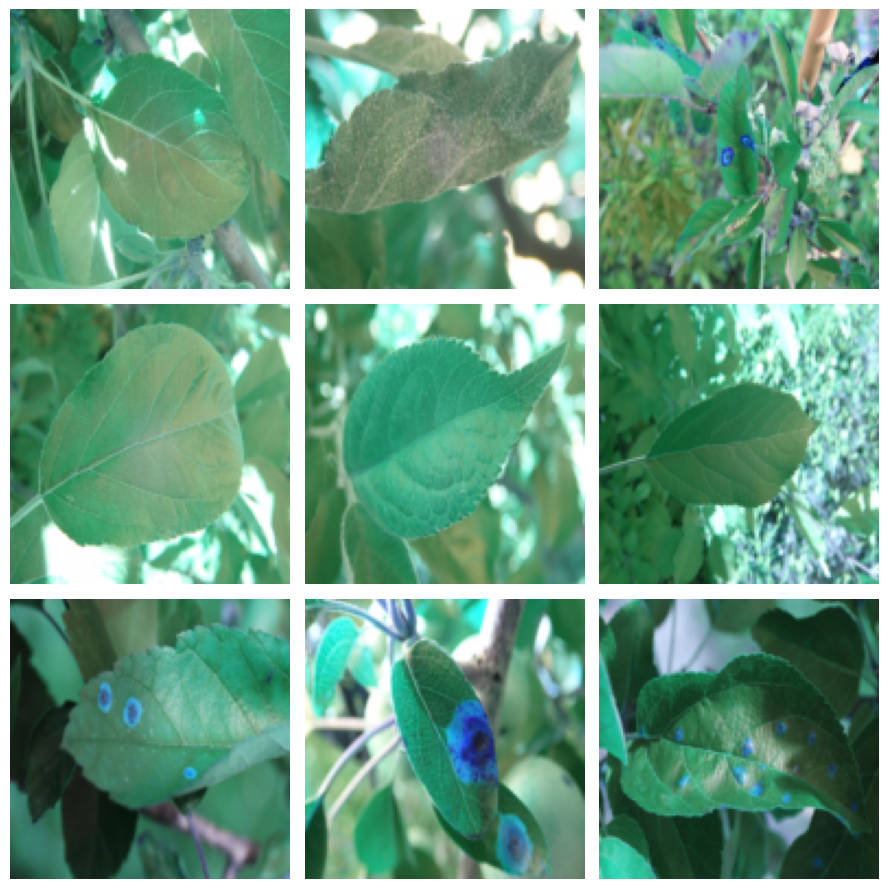

In [42]:
ims, labels = next(iter(train_loader))
ims = torch.einsum("bchw->bhwc", ims)
rows, cols = 3, 3
ims = ims[:rows*cols].view(rows, cols, 128, 128, 3)
fig, axs = plt.subplots(rows, cols, figsize=(3*rows, 3*cols))
for A, I in zip(axs,ims):
    for ax, img in zip(A,I):
        ax.set_aspect('equal')
        ax.axis('off')
        ax.imshow(img)
fig.tight_layout()
#fig.subplots_adjust(hspace=0, wspace=0)
#plt.savefig(save_fig_path, facecolor='w', edgecolor='none')
plt.show()


### Define RESNET model

In [43]:
"""
conv1: 512 -> 256 : 8       |   conv1: 128 -> 64 : 8
conv2: 256 -> 128 : 16      |   conv2: 64 -> 32 : 16
res                         |   res
conv3: 128 -> 64 : 32       |   conv3: 32 -> 16 : 32
conv4: 64 -> 32 : 64        |   conv4: 16 -> 8 : 64
res                         |   res
conv5: 32 -> 16 : 128       |   conv5: 8 -> 4 : 128
conv6: 16 -> 8 : 256        |   conv6: 4 -> 2 : 256
res                         |   res
conv7: 8 -> 4 : 512         |   conv7: 2 -> 1 : 512
conv8: 4 -> 2 : 1024        |   conv8: 1 -> 1 : 1024
res                         |   res
flatten: 1024 x 2 x 2       |   flatten: 1024 x 1 x 1
linear1: 512                |   linear1: 512
linear2: 128                |   linear2: 128
linear3: 32                 |   linear3: 32
linear4: 3                  |   linear4: 3
"""

# Conv block used in Resnet model
def conv_block(in_channels, out_channels, pool=False, kernel_size=3):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding='same'),
              nn.BatchNorm2d(out_channels),
              nn.Dropout(0.2),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Linear layer block
def linear_block(in_features, out_features, activation=True, batchnorm=False, flatten=False):
    layers = []
    if flatten:
        layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features, out_features))
    #layers.append(nn.Dropout(0.1))
    if batchnorm:
        layers.append(nn.BatchNorm1d(out_features))
    if activation:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# Resnet9
class RESNET20(nn.Module):
    def __init__(self, in_channels, num_classes, nf):
        super(RESNET20, self).__init__()
        self.conv1 = conv_block(in_channels, nf, pool=True)
        self.conv2 = conv_block(nf, 2*nf, pool=True)
        self.res1 = nn.Sequential(conv_block(2*nf, 2*nf), conv_block(2*nf, 2*nf))

        self.conv3 = conv_block(2*nf, 4*nf, pool=True)
        self.conv4 = conv_block(4*nf, 8*nf, pool=True)
        self.res2 = nn.Sequential(conv_block(8*nf, 8*nf), conv_block(8*nf, 8*nf))

        self.conv5 = conv_block(8*nf, 16*nf, pool=True)
        self.conv6 = conv_block(16*nf, 32*nf, pool=True)
        self.res3 = nn.Sequential(conv_block(32*nf, 32*nf), conv_block(32*nf, 32*nf))

        self.conv7 = conv_block(32*nf, 64*nf, pool=True)
        self.conv8 = conv_block(64*nf, 128*nf, pool=False, kernel_size=1)
        self.res4 = nn.Sequential(conv_block(128*nf, 128*nf, kernel_size=1), conv_block(128*nf, 128*nf, kernel_size=1))

        # dense layers
        self.fc1 = linear_block(128*nf*1*1, 512, flatten=True, batchnorm=True)
        self.fc2 = linear_block(512, 128, batchnorm=True)
        self.fc3 = linear_block(128, 32, batchnorm=True)
        self.fc4 = linear_block(32, num_classes, activation=False, batchnorm=True)

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = self.res1(x) + x
        x = self.conv4(self.conv3(x))
        x = self.res2(x) + x
        x = self.conv6(self.conv5(x))
        x = self.res3(x) + x
        x = self.conv8(self.conv7(x))
        x = self.res4(x) + x
        x = self.fc2(self.fc1(x))
        return self.fc4(self.fc3(x))


In [44]:
torch.cuda.empty_cache()

In [45]:
# test the model and output shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_input = torch.randn((64,3,128,128)).to(device)
test_model = RESNET20(3,3,8).to(device)
test_out = test_model(test_input)
test_out.shape

torch.Size([64, 3])

In [46]:
def save_plots(losses, name=None):
    pathlib.Path("results").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_plot_path = "results/plot-"+timestr
    else:
        save_plot_path = "results/"+name
    epochs = len(losses['train_loss'])
    plt.plot(range(1,epochs+1), losses['train_loss'], label='Train loss')
    plt.plot(range(1,epochs+1), losses['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Losses")
    plt.savefig(save_plot_path, facecolor='w', edgecolor='none')
    plt.show()

def save_model(model, name=None):
    pathlib.Path("results/saved_models").mkdir(parents=True, exist_ok=True)
    if not name:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_model_path = "results/saved_models/"+timestr+".pth"
    else:
        save_model_path = "results/saved_models/"+name+".pth"
    torch.save(model.state_dict(), save_model_path)

In [47]:
def train_model(model, device, train_loader, loss_criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    total = 0
    total_acc = 0
    epoch_losses = []
    for batchidx, (data, target) in enumerate(train_loader):
        #print(f'batch id: {batchidx}')
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        #print(f'predictions: {predictions.shape}, target: {target.shape}')
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        total_acc += (correct/len(data))
        total += len(data)
    avg_acc = total_acc/len(train_loader)
    avg_loss = train_loss/total
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\tAcc: {100. * avg_acc:.6f}%")
    return 100. * avg_acc, avg_loss

def test_model(model, device, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item()
            predictions = output.argmax(dim=1, keepdim=True)
            #print(f'predictions: {predictions.shape}, target: {target.shape}')
            correct += predictions.eq(target.view_as(predictions)).sum().item()
            total += len(data)
    test_loss /= total
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({100. * correct/total:.0f}%)")
    return 100. * correct/total, test_loss


using device: cuda
Layer (type:depth-idx)                   Param #
RESNET20                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─BatchNorm2d: 2-2                  32
│    └─Dropout: 2-3                      --
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       4,640
│    └─BatchNorm2d: 2-7                  64
│    └─Dropout: 2-8                      --
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Sequential: 2-11                  --
│    │    └─Conv2d: 3-1                  9,248
│    │    └─BatchNorm2d: 3-2             64
│    │    └─Dropout: 3-3                 --
│    │    └─ReLU: 3-4                    --
│    └─Sequential: 2-12                  --
│    │    └─Conv2d: 3-5                  9,24

Train epoch: 1 [1280/1322          (95%)]	Loss: 0.018167	Acc: 36.250000%
Test set: Average loss: 0.0175, Accuracy: 36/128 (28%)
Train epoch: 2 [1280/1322          (95%)]	Loss: 0.016579	Acc: 43.593750%
Test set: Average loss: 0.0172, Accuracy: 50/128 (39%)
Train epoch: 3 [1280/1322          (95%)]	Loss: 0.015496	Acc: 52.109375%
Test set: Average loss: 0.0177, Accuracy: 50/128 (39%)
Train epoch: 4 [1280/1322          (95%)]	Loss: 0.014162	Acc: 60.390625%
Test set: Average loss: 0.0191, Accuracy: 50/128 (39%)
Train epoch: 5 [1280/1322          (95%)]	Loss: 0.012052	Acc: 66.718750%
Test set: Average loss: 0.0191, Accuracy: 50/128 (39%)
Train epoch: 6 [1280/1322          (95%)]	Loss: 0.010474	Acc: 72.265625%
Test set: Average loss: 0.0261, Accuracy: 50/128 (39%)
Train epoch: 7 [1280/1322          (95%)]	Loss: 0.009337	Acc: 75.546875%
Test set: Average loss: 0.0269, Accuracy: 50/128 (39%)
Train epoch: 8 [1280/1322          (95%)]	Loss: 0.007967	Acc: 82.421875%
Test set: Average loss: 0.0301,

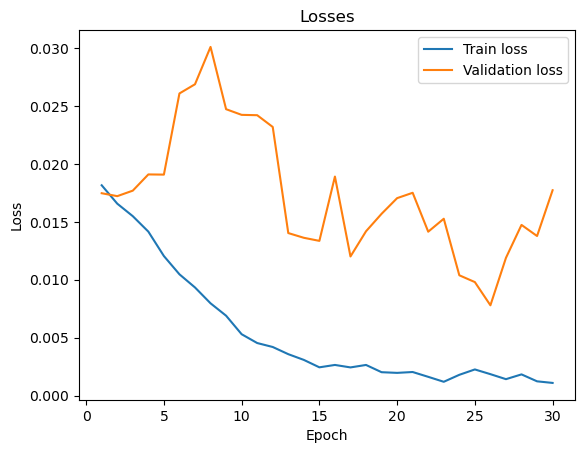

In [ ]:
num_classes = 3
num_filters = 1
learning_rate = 0.01
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_criterion = nn.CrossEntropyLoss()
inp_channels = 3
model = RESNET20(inp_channels, num_classes, num_filters).to(device=device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

losses = defaultdict(list)

print(f"using device: {device}")
print(summary(model))

for epoch in range(1,num_epochs+1):
    _, tloss = train_model(model, device, train_loader, loss_criterion, optimizer, epoch)
    losses['train_loss'].append(tloss)
    _, vloss = test_model(model, device, test_loader, loss_criterion)
    losses['val_loss'].append(vloss)

# save plots
save_plots(losses, 'mnist-loss')

#save model
save_model(model, 'mnist_sample_model')

In [ ]:
len(test_set)